#**3. Modelling**

Big supermarket chain restock daily so we will focus on daily sales forecast. In this section, we will first explore nationwide daily sales forecast, then go down to store level (top 14 stores that contribute 50% revenue). We will be using 2 main methods:
* Univariate Time Series Forecasting (ARIMA, SARIMA, AR, MA, etc.): These methods are capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.
* Multivariate Time Series Forecasting: Linear, Tree, XGBoost

In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')

#import basic functions 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import scale
import warnings
import itertools

#import packages for modelling
# from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import xgboost as xgb
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

Mounted at /content/drive


In [ ]:
EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)

def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


**Preparation before modeling**

In [ ]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

url = '/content/drive/MyDrive/Springboard/Capstone3/daily_sales_agg.csv'
sales_agg = pd.read_csv(url, parse_dates=['date'])
sales_agg = sales_agg.set_index('date').asfreq('d')

In [ ]:
#Test set without sales data from 2017-08-16 to 2017-08-31
sales_agg["sales_yst"] = sales_agg['sales'].shift(1, axis = 0)
sales_agg = sales_agg[1:]
split_date_1 = '2017-08-15'
df_train = sales_agg.loc[sales_agg.index <= split_date_1]
df_test = sales_agg.loc[sales_agg.index > split_date_1]
split_date_2 = '2016-08-31'
df_training = df_train.loc[df_train.index <= split_date_2]
df_val = df_train.loc[df_train.index > split_date_2]

print(f"{len(df_training)} days of training data \n {len(df_val)} days of validating data \n {len(df_test)} days of testing data ")

1338 days of training data 
 349 days of validating data 
 16 days of testing data 


In [ ]:
#Fix NaN sales in df_train, df_training, df_val
df_training['sales'] = df_training['sales'].fillna(method = 'ffill')
df_val['sales'] = df_val['sales'].fillna(method = 'ffill')
df_train['sales'] = df_train['sales'].fillna(method = 'ffill')
df_training['sales_yst'] = df_training['sales_yst'].fillna(method = 'ffill')
df_val['sales_yst'] = df_val['sales_yst'].fillna(method = 'ffill')
df_train['sales_yst'] = df_train['sales_yst'].fillna(method = 'ffill')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# Also add the naive mean average value
mean = df_training.sales.mean()
mean = np.array([mean for u in range(len(df_val))])
resultsDict['Naive mean'] = mape(df_val.sales, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = mape(df_val.sales, df_val.sales_yst)
predictionsDict['Yesterdays value'] = df_val.sales_yst.values

It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

##**3.1.Nationwide Daily Sales Prediction**

###**3.1.1. Univariate Time Series Forecasting**

* In this section we will focus on time series forecasting methods capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.

* ARIMA models: the data became stationary after one difference so we set d = 1 and vary p and q values from 0 to 3

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
p = q = range(0,4)
d = [1]
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

for param in pdq:
  # for param_seasonal in seasonal_pdq:
    index = len(df_training)
    yhat = list()
    for t in tqdm(range(len(df_val.sales))):
      temp_train = sales_agg[:len(df_training)+t]
      model = ARIMA(temp_train.sales, order=param,enforce_invertibility=True )
      model.initialize_approximate_diffuse() 
      model_fit = model.fit()
      predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
      yhat = yhat + [predictions]

    yhat = pd.concat(yhat)
    resultsDict['ARIMA'+str(param)] = mape(df_val.sales, yhat.values)
    predictionsDict['ARIMA'+str(param)] = yhat.values

 36%|███▌      | 124/349 [00:24<00:43,  5.22it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
  0%|          | 0/349 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
  0%|          | 0/349 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  0%|          | 1/349 [00:01<11:12,  1.93s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Conve

In [ ]:
min_value = min(resultsDict, key=resultsDict.get)
print(min_value)

ARIMA(0, 1, 2)


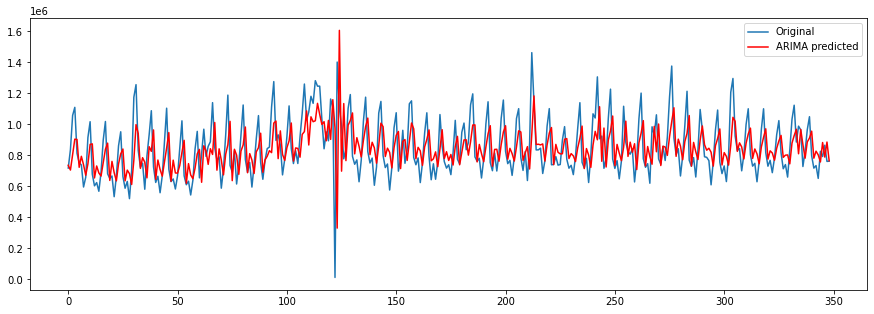

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df_val.sales.values, label='Original')
plt.plot(predictionsDict[min_value], color='red', label='ARIMA predicted')
plt.legend()

###**3.1.2. Multivariate Time Series Prediction**

In [ ]:
# ADD time features to our model
def create_time_features(df, target):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
cols = ['sales','sales_yst','CPI','POP','oil']
X_train_df, y_train = create_time_features(df_training[cols], 'sales')
X_val_df, y_val = create_time_features(df_val[cols], 'sales')
X_test_df, y_test = create_time_features(df_test[cols], 'sales')
scaler = StandardScaler()
scaler.fit(X_train_df) 
X_train = scaler.transform(X_train_df)
X_val = scaler.transform(X_val_df)
# X_test = scaler.transform(X_test_df)
X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_val_df = pd.DataFrame(X_val, columns=X_val_df.columns)
# X_test_df = pd.DataFrame(X_test, columns=X_val_df.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

####**3.1.2.1.Linear**

**Bayesian**

In [ ]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_val)
resultsDict['BayesianRidge'] = mape(df_val.sales, yhat)
predictionsDict['BayesianRidge'] = yhat

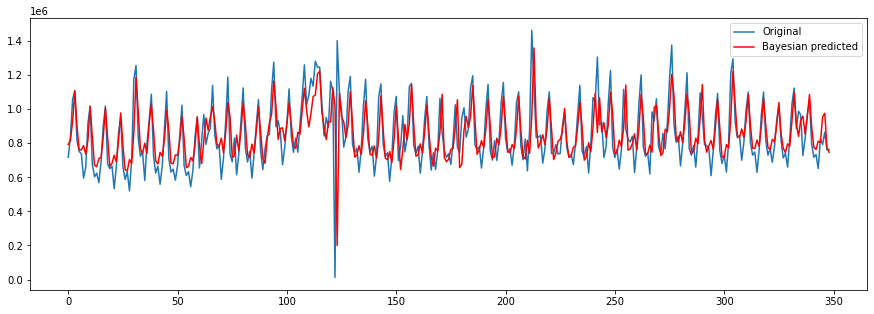

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df_val.sales.values, label='Original')
plt.plot(yhat, color='red', label='Bayesian predicted')
plt.legend()

**Lasso**

In [ ]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_val)
resultsDict['Lasso'] = mape(df_val.sales, yhat)
predictionsDict['Lasso'] = yhat

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.433e+12, tolerance: 6.130e+09
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


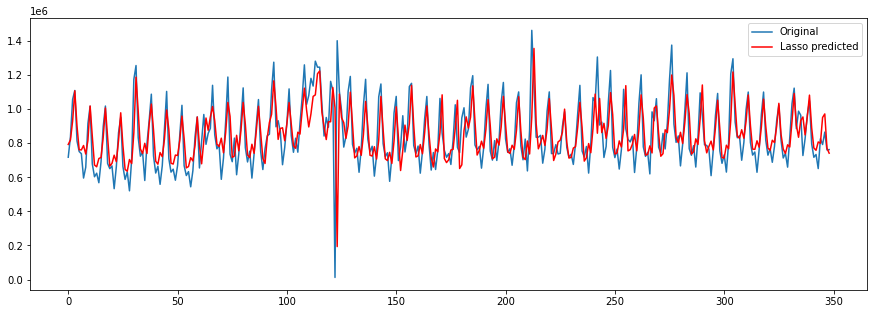

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df_val.sales.values, label='Original')
plt.plot(yhat, color='red', label='Lasso predicted')
plt.legend()

In [ ]:
resultsDict

{'Naive mean': 0.42163934738869246,
 'Yesterdays value': 0.4426052678575726,
 'ARIMA(0, 1, 0)': 0.4426052678575726,
 'ARIMA(0, 1, 1)': 0.41675585526066516,
 'ARIMA(0, 1, 2)': 0.3772667673729956,
 'ARIMA(0, 1, 3)': 0.3797005978687628,
 'ARIMA(1, 1, 0)': 0.4437210519700551,
 'ARIMA(1, 1, 1)': 0.40323377144874784,
 'ARIMA(1, 1, 2)': 0.37845039975504746,
 'ARIMA(1, 1, 3)': 0.3819979626870693,
 'ARIMA(2, 1, 0)': 0.4155602397276448,
 'ARIMA(2, 1, 1)': 0.3863896574438307,
 'ARIMA(2, 1, 2)': 0.3800159465825428,
 'ARIMA(2, 1, 3)': 0.3860891885260407,
 'ARIMA(3, 1, 0)': 0.41554817925200815,
 'ARIMA(3, 1, 1)': 0.3858589676366877,
 'ARIMA(3, 1, 2)': 0.38022182655429104,
 'ARIMA(3, 1, 3)': 0.4000399330779972,
 'BayesianRidge': 0.3491692029437708,
 'Lasso': 0.346581604609881}

####**3.1.2.3. Tree**

**Random Forest**

In [ ]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_val)
resultsDict['Randomforest'] = mape(df_val.sales, yhat)
predictionsDict['Randomforest'] = yhat

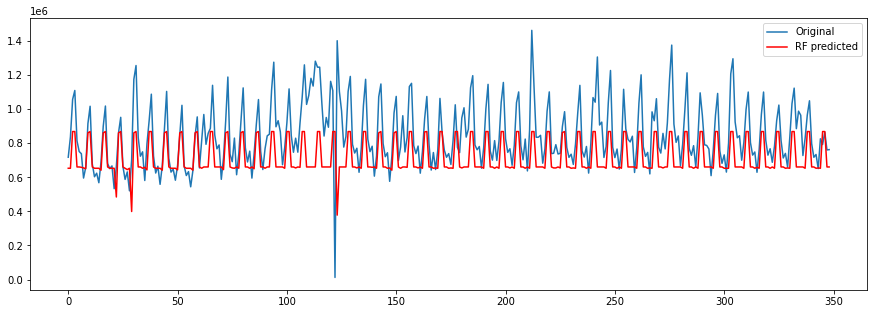

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df_val.sales.values, label='Original')
plt.plot(yhat, color='red', label='RF predicted')
plt.legend()

In [ ]:
resultsDict

{'Naive mean': 0.42163934738869246,
 'Yesterdays value': 0.4426052678575726,
 'ARIMA(0, 1, 0)': 0.4426052678575726,
 'ARIMA(0, 1, 1)': 0.41675585526066516,
 'ARIMA(0, 1, 2)': 0.3772667673729956,
 'ARIMA(0, 1, 3)': 0.3797005978687628,
 'ARIMA(1, 1, 0)': 0.4437210519700551,
 'ARIMA(1, 1, 1)': 0.40323377144874784,
 'ARIMA(1, 1, 2)': 0.37845039975504746,
 'ARIMA(1, 1, 3)': 0.3819979626870693,
 'ARIMA(2, 1, 0)': 0.4155602397276448,
 'ARIMA(2, 1, 1)': 0.3863896574438307,
 'ARIMA(2, 1, 2)': 0.3800159465825428,
 'ARIMA(2, 1, 3)': 0.3860891885260407,
 'ARIMA(3, 1, 0)': 0.41554817925200815,
 'ARIMA(3, 1, 1)': 0.3858589676366877,
 'ARIMA(3, 1, 2)': 0.38022182655429104,
 'ARIMA(3, 1, 3)': 0.4000399330779972,
 'BayesianRidge': 0.3491692029437708,
 'Lasso': 0.346581604609881,
 'Randomforest': 0.3608201445571508}

**XGBoost**

In [ ]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train, verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_val)
resultsDict['XGBoost'] = mape(df_val.sales, yhat)
predictionsDict['XGBoost'] = yhat

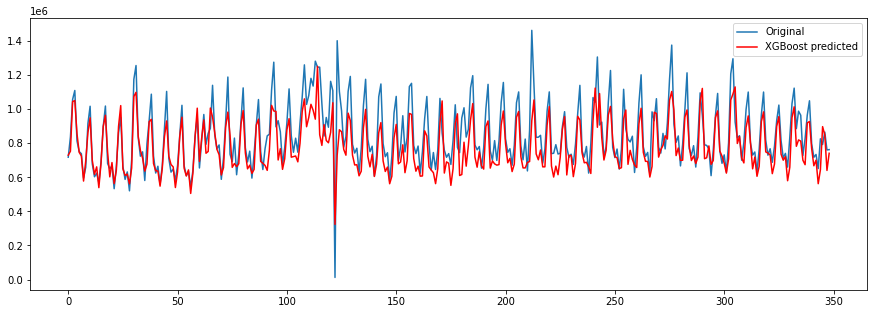

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df_val.sales.values, label='Original')
plt.plot(yhat, color='red', label='XGBoost predicted')
plt.legend()

In [ ]:
resultsDict

{'Naive mean': 0.42163934738869246,
 'Yesterdays value': 0.4426052678575726,
 'ARIMA(0, 1, 0)': 0.4426052678575726,
 'ARIMA(0, 1, 1)': 0.41675585526066516,
 'ARIMA(0, 1, 2)': 0.3772667673729956,
 'ARIMA(0, 1, 3)': 0.3797005978687628,
 'ARIMA(1, 1, 0)': 0.4437210519700551,
 'ARIMA(1, 1, 1)': 0.40323377144874784,
 'ARIMA(1, 1, 2)': 0.37845039975504746,
 'ARIMA(1, 1, 3)': 0.3819979626870693,
 'ARIMA(2, 1, 0)': 0.4155602397276448,
 'ARIMA(2, 1, 1)': 0.3863896574438307,
 'ARIMA(2, 1, 2)': 0.3800159465825428,
 'ARIMA(2, 1, 3)': 0.3860891885260407,
 'ARIMA(3, 1, 0)': 0.41554817925200815,
 'ARIMA(3, 1, 1)': 0.3858589676366877,
 'ARIMA(3, 1, 2)': 0.38022182655429104,
 'ARIMA(3, 1, 3)': 0.4000399330779972,
 'BayesianRidge': 0.3491692029437708,
 'Lasso': 0.346581604609881,
 'Randomforest': 0.3608201445571508,
 'XGBoost': 0.17198714678625432}

In [ ]:
results=pd.DataFrame()
results['columns']=X_train_df.columns
results['importances'] = reg.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

results[:20]

,columns,importances
4,dayofweek,0.271026
0,sales_yst,0.269558
2,POP,0.167344
8,dayofyear,0.066355
3,oil,0.056128
6,month,0.046627
1,CPI,0.036275
11,dayofmonth,0.032070
12,weekofyear,0.028756
10,cos_day,0.011132


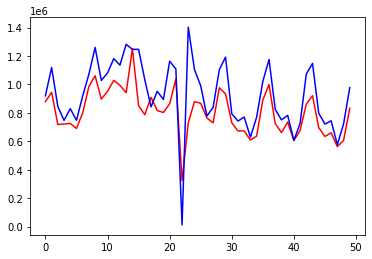

In [ ]:
#Inspect the dip
plt.plot(yhat[100:150], color = 'r')
plt.plot(df_val.sales.to_numpy()[100:150], color = 'b')

The dip happens at point #22, Sunday, and the first day of the year. This is when many of the stores are closed, hence big dip every year. 







In [ ]:
#Plot external features to check whether they inform this dip 
Ori_val_df = pd.DataFrame(scaler.inverse_transform(X_val_df[100:150]),columns=X_val_df.columns)
sales = y_val[100:150].to_list()
Ori_val_df = Ori_val_df.assign(sales = sales)

In [ ]:
Ori_val_df[Ori_val_df['sales'] == Ori_val_df['sales'].min(axis = 0)]

,sales_yst,CPI,POP,oil,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear,sales
22,1.109013e+06,0.417336,16785356.0,53.75,6.0,1.0,1.0,2017.0,1.0,0.841471,0.540302,1.0,52.0,12082.500997


In [ ]:
Ori_val_df[15:28]

,sales_yst,CPI,POP,oil,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear,sales
15,1.246838e+06,1.728265,16491116.0,52.01,6.0,4.0,12.0,2016.0,360.0,0.958916,-0.283691,25.0,51.0,1.246838e+06
16,1.246838e+06,1.728265,16491116.0,52.01,0.0,4.0,12.0,2016.0,361.0,0.279387,-0.960179,26.0,52.0,1.032771e+06
17,1.032771e+06,1.728265,16491116.0,52.82,1.0,4.0,12.0,2016.0,362.0,-0.657009,-0.753882,27.0,52.0,8.424755e+05
18,8.424755e+05,1.728265,16491116.0,54.01,2.0,4.0,12.0,2016.0,363.0,-0.989354,0.145530,28.0,52.0,9.515337e+05
19,9.515337e+05,1.728265,16491116.0,53.80,3.0,4.0,12.0,2016.0,364.0,-0.412091,0.911143,29.0,52.0,8.941082e+05
20,8.941082e+05,1.728265,16491116.0,53.75,4.0,4.0,12.0,2016.0,365.0,0.544046,0.839055,30.0,52.0,1.163643e+06
21,1.163643e+06,1.728265,16491116.0,53.75,5.0,4.0,12.0,2016.0,366.0,0.999990,-0.004456,31.0,52.0,1.109013e+06
22,1.109013e+06,0.417336,16785356.0,53.75,6.0,1.0,1.0,2017.0,1.0,0.841471,0.540302,1.0,52.0,1.208250e+04
23,1.208250e+04,0.417336,16785356.0,53.75,0.0,1.0,1.0,2017.0,2.0,0.909297,-0.416147,2.0,1.0,1.402306e+06
24,1.402306e+06,0.417336,16785356.0,52.36,1.0,1.0,1.0,2017.0,3.0,0.141120,-0.989992,3.0,1.0,1.104377e+06


###**3.1.3. Hyperparameter tunning**

In [ ]:
# import pandas for data wrangling
import pandas as pd

# import numpy for Scientific computations
import numpy as np

# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
#Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    clf=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), verbosity = 0)
    
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="mae",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_val)
    loss = mape(y_val, pred)
    print ("SCORE:", loss)
    return {'loss': loss, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,\
                        space = space,\
                        algo = tpe.suggest,\
                        max_evals = 100,\
                        trials = trials)

SCORE:
0.30980180457580075
SCORE:
0.2934478303909228
SCORE:
0.26814019281268126
SCORE:
0.3032677825319228
SCORE:
0.3137622529513184
SCORE:
0.2784405426706469
SCORE:
0.2757607726652403
SCORE:
0.317562818787525
SCORE:
0.29229311961731547
SCORE:
0.2932640862576567
SCORE:
0.25549926175159077
SCORE:
0.30333970255784165
SCORE:
0.29451701061054264
SCORE:
0.28163202985771674
SCORE:
0.2593396115058704
SCORE:
0.2557398353769667
SCORE:
0.2604906774355941
SCORE:
0.29262891859019347
SCORE:
0.251250793917044
SCORE:
0.2898249496845244
SCORE:
0.2684108034280344
SCORE:
0.2592308864367587
SCORE:
0.251040419567972
SCORE:
0.25431608581687637
SCORE:
0.25678102311986245
SCORE:
0.25923922257803195
SCORE:
0.28707705142894235
SCORE:
0.2705046317933458
SCORE:
0.26183839064163766
SCORE:
0.291195452450739
SCORE:
0.2595785534305099
SCORE:
0.24957620010851353
SCORE:
0.25011662248364186
SCORE:
0.2917337295611145
SCORE:
0.25305973670606796
SCORE:
0.2927525400327809
SCORE:
0.25653945900914643
SCORE:
0.2905839099608718

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6128220080898538, 'gamma': 2.413762383626327, 'max_depth': 7.0, 'min_child_weight': 3.0, 'reg_alpha': 170.0, 'reg_lambda': 0.7022946032062614}


In [ ]:
#Train the model on both train and validation dataset 
cols = ['sales','sales_yst','CPI','POP','oil']
X_df, y = create_time_features(df_train[cols], "sales")
scaler = StandardScaler()
scaler.fit(X_df) 
X = scaler.transform(X_df)
parameters = {"objective": "reg:squarederror",
              "colsample_bytree": 0.5386589954893073,
              "gamma": 1.500538354213392,
              "max_depth": 9,
              "min_child_weight": 3,
              "reg_alpha": 145,
              "reg_lambda": 0.20927620338609632, 
              "verbosity": 0}

reg = xgb.XGBRegressor(**parameters)
reg.fit(X, y, verbose=False) 
yhat = reg.predict(X)
print(mape(y, yhat))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

0.015901776350444458


In [ ]:
X_test_df = X_test_df.reset_index().drop('date', axis = 1)

In [ ]:
#Use the model to predict test set
result = []
for i, row in X_test_df.iterrows():
    X_test = scaler.transform(X_test_df[i:i+1])
    result.append(reg.predict(X_test))
    X_test_df.loc[i+1, "sales_yst"] = reg.predict(X_test)


In [ ]:
yhat = np.concatenate( result, axis=0 )

In [ ]:
yhat

array([811938.75, 658262.3 , 792868.9 , 899857.2 , 976108.25, 776766.44,
       746938.06, 751197.1 , 631227.06, 780032.3 , 877357.  , 954494.75,
       762340.06, 762513.44, 817098.3 , 665477.2 ], dtype=float32)

##**3.2. Store sales prediction**

###**3.2.1. Train model for each store**

We use the same parameters as the above as sales from these top stores are highly correlated with the aggregated daily sales nationwide. We will then fit data from each store to the model and use that to predict the corresponding store's test dataset

In [ ]:
url = '/content/drive/MyDrive/Springboard/Capstone3/daily_sales_stores.csv'
sales = pd.read_csv(url, parse_dates=['date'])
sales['sales_yst'] = sales.groupby('store_nbr')['sales'].shift(1, axis = 0)
train = sales[sales.date <= '2017-08-15']
test = sales[sales.date > '2017-08-15']

In [ ]:
#fill 0 values with 3 day moving average 
def fill_0(df,target):
  for i, row in df.iterrows():
    if row[target] == 0:
        df.loc[i,target] = df[target].iloc[(i-3):i].mean()
  return df

In [ ]:
#Create a dataframe for each store, exclude the first day 2013-01-01
top_stores = [44,45,47,3,49,46,48,51,8,50,11,7,9,6]
store_dict_test = {}
store_dict_train = {}
for store in top_stores:
  store_dict_test[store] = test[test['store_nbr'] == store]
  store_dict_test[store] = store_dict_test[store].reset_index()
  store_dict_test[store] = store_dict_test[store].set_index('date')
  store_dict_train[store] = train[(train['store_nbr'] == store)&(train['date'] > '2013-01-02')]
  store_dict_train[store].reset_index(inplace = True)
  store_dict_train[store].drop('index', axis = 1, inplace = True)
  store_dict_train[store] = fill_0(store_dict_train[store],'sales')
  store_dict_train[store] = fill_0(store_dict_train[store],'sales_yst')
  store_dict_train[store]['sales_yst'] = store_dict_train[store]['sales_yst'].fillna(method = 'ffill')
  store_dict_train[store]['sales'] = store_dict_train[store]['sales'].fillna(method = 'ffill')
  store_dict_train[store] = store_dict_train[store].set_index('date')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
#Train model for each store
model = {}

for store, df in store_dict_train.items():
  cols = ['sales','sales_yst','CPI','POP','oil']
  X_df, y = create_time_features(df[cols], "sales")
  scaler = StandardScaler()
  scaler.fit(X_df) 
  X = scaler.transform(X_df)
  parameters = {"objective": "reg:squarederror",
              "colsample_bytree": 0.5386589954893073,
              "gamma": 1.500538354213392,
              "max_depth": 9,
              "min_child_weight": 3,
              "reg_alpha": 145,
              "reg_lambda": 0.20927620338609632, 
              "verbosity": 0}
  reg = xgb.XGBRegressor(**parameters)
  reg.fit(X, y, verbose=False) 
  model[store] = reg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

###**3.2.2. Predict sales for each store**

In [ ]:
#Predict sales for each store
prediction = {}
for store, df in store_dict_test.items():
  cols = ['sales','sales_yst','CPI','POP','oil']
  X_df, y = create_time_features(df[cols], "sales")
  X_df = X_df.reset_index().drop('date', axis = 1)
  pred = []
  for i, row in X_df.iterrows():
    X = scaler.transform(X_df[i:i+1])
    yhat = model[store].predict(X)
    X_df.loc[i+1, "sales_yst"] = yhat
    pred.append(yhat)
  prediction[store] = np.concatenate(pred, axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
prediction

{44: array([51910.59 , 40356.28 , 51606.793, 57970.855, 56596.01 , 48996.367,
        53548.176, 48792.137, 42543.844, 50804.56 , 55395.45 , 57399.45 ,
        51794.785, 53349.156, 50590.535, 45262.105], dtype=float32),
 45: array([40235.633, 36192.266, 43519.848, 49121.36 , 52164.523, 37771.78 ,
        37494.98 , 39224.49 , 36139.79 , 43342.668, 50176.93 , 53165.277,
        36684.09 , 38129.914, 38968.543, 41327.297], dtype=float32),
 47: array([37146.527, 36119.297, 44404.125, 47580.246, 50691.01 , 35673.367,
        37437.18 , 36047.207, 35185.367, 42659.69 , 47211.332, 50728.125,
        36045.23 , 36317.676, 36789.387, 34345.332], dtype=float32),
 3: array([43387.816, 37320.137, 43307.57 , 46271.145, 44151.477, 42123.453,
        42852.977, 44932.25 , 34100.594, 40479.203, 43241.93 , 44619.45 ,
        41600.285, 42732.652, 45473.453, 34835.664], dtype=float32),
 49: array([41011.684, 36510.78 , 43925.824, 42392.375, 44064.645, 40230.547,
        37763.37 , 42461.18 , 35880.293

##**3.3. Category sales prediction**

###**3.3.1. Train model for each family**

In [ ]:
url = '/content/drive/MyDrive/Springboard/Capstone3/daily_sales_family.csv'
sales = pd.read_csv(url, parse_dates=['date'])
sales['sales_yst'] = sales.groupby('family')['sales'].shift(1, axis = 0)
train = sales[sales.date <= '2017-08-15']
test = sales[sales.date > '2017-08-15']

In [ ]:
#Create a dataframe for each store, exclude the first day 2013-01-01
fam = ['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY',
       'BREAD/BAKERY', 'POULTRY', 'MEATS', 'PERSONAL CARE', 'DELI',
       'HOME CARE', 'EGGS', 'FROZEN FOODS', 'PREPARED FOODS',
       'LIQUOR,WINE,BEER', 'SEAFOOD', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'CELEBRATION', 'LINGERIE', 'LADIESWEAR',
       'PLAYERS AND ELECTRONICS', 'AUTOMOTIVE', 'LAWN AND GARDEN',
       'PET SUPPLIES', 'BEAUTY', 'SCHOOL AND OFFICE SUPPLIES', 'MAGAZINES',
       'HARDWARE', 'HOME APPLIANCES', 'BABY CARE', 'BOOKS']
fam_dict_test = {}
fam_dict_train = {}
for f in fam:
  fam_dict_test[f] = test[test['family'] == f]
  fam_dict_test[f] = fam_dict_test[f].reset_index()
  fam_dict_test[f] = fam_dict_test[f].set_index('date')
  fam_dict_train[f] = train[(train['family'] == f)&(train['date'] > '2013-01-02')]
  fam_dict_train[f].reset_index(inplace = True)
  fam_dict_train[f].drop('index', axis = 1, inplace = True)
  fam_dict_train[f] = fill_0(fam_dict_train[f],'sales')
  fam_dict_train[f] = fill_0(fam_dict_train[f],'sales_yst')
  fam_dict_train[f]['sales_yst'] = fam_dict_train[f]['sales_yst'].fillna(method = 'ffill')
  fam_dict_train[f]['sales'] = fam_dict_train[f]['sales'].fillna(method = 'ffill')
  fam_dict_train[f] = fam_dict_train[f].set_index('date')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [ ]:
#Train model for each family
model = {}

for f, df in fam_dict_train.items():
  cols = ['sales','sales_yst','CPI','POP','oil']
  X_df, y = create_time_features(df[cols], "sales")
  scaler = StandardScaler()
  scaler.fit(X_df) 
  X = scaler.transform(X_df)
  parameters = {"objective": "reg:squarederror",
              "colsample_bytree": 0.5386589954893073,
              "gamma": 1.500538354213392,
              "max_depth": 9,
              "min_child_weight": 3,
              "reg_alpha": 145,
              "reg_lambda": 0.20927620338609632, 
              "verbosity": 0}
  reg = xgb.XGBRegressor(**parameters)
  reg.fit(X, y, verbose=False) 
  model[f] = reg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

###**3.3.2. Predict sales for each product family**

In [ ]:
#Predict sales for each family
prediction = {}
for f, df in fam_dict_test.items():
  cols = ['sales','sales_yst','CPI','POP','oil']
  X_df, y = create_time_features(df[cols], "sales")
  X_df = X_df.reset_index().drop('date', axis = 1)
  pred = []
  for i, row in X_df.iterrows():
    X = scaler.transform(X_df[i:i+1])
    yhat = model[f].predict(X)
    X_df.loc[i+1, "sales_yst"] = yhat
    pred.append(yhat)
  prediction[f] = np.concatenate(pred, axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
prediction 

{'GROCERY I': array([394863.6 , 396511.72, 404454.62, 392642.72, 392270.22, 395826.06,
        400998.72, 395499.22, 376753.06, 384925.16, 385767.97, 385447.3 ,
        391679.  , 386868.44, 383182.3 , 390946.53], dtype=float32),
 'BEVERAGES': array([200225.34, 193879.31, 206229.36, 240893.42, 237574.2 , 192721.83,
        204367.75, 196721.36, 188007.39, 198136.84, 237515.52, 237104.34,
        194756.58, 194237.19, 196510.39, 184822.39], dtype=float32),
 'PRODUCE': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5], dtype=float32),
 'CLEANING': array([71744.375, 73192.33 , 74142.84 , 84584.76 , 91898.95 , 74475.375,
        76239.45 , 70660.33 , 75836.445, 75085.664, 85407.055, 88721.63 ,
        75269.09 , 71510.6  , 79051.19 , 75119.445], dtype=float32),
 'DAIRY': array([49773.13 , 44123.23 , 48012.793, 53891.066, 55335.453, 47123.566,
        47041.215, 48842.46 , 44577.387, 47951.465, 52812.855, 54760.805,
        46011.31 , 45360.12 , 